wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sooreal91 (sooreal91-free). Use `wandb login --relogin` to force relogin


사용할 디바이스: mps
Using cache found in /Users/soojin/.cache/torch/hub/huggingface_pytorch-transformers_main
DistilBERT 토크나이저 로딩 완료 (소요시간: 2.36초)


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

AG News 데이터셋 로드 완료 (소요시간: 5.87초)
데이터셋 구조: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
DataLoader 준비 완료. Train 샘플: 120000, Test 샘플: 7600
Using cache found in /Users/soojin/.cache/torch/hub/huggingface_pytorch-transformers_main
DistilbertNewsClassifier 생성 및 DistilBERT 동결(Freeze) 완료.
학습 준비 완료: Loss=CrossEntropyLoss(), LR=0.001, Epoch=3
학습 루프 시작...
====== 에폭 1/3 시작 ======
Epoch 1/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [11:13<00:00,  2.78batch/s]
에폭 1/3 종료 -> 평균 Train Loss: 0.4689, Test Acc: 0.872, 에폭 시간: 708.74초
====== 에폭 2/3 시작 ======
Epoch 2/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|

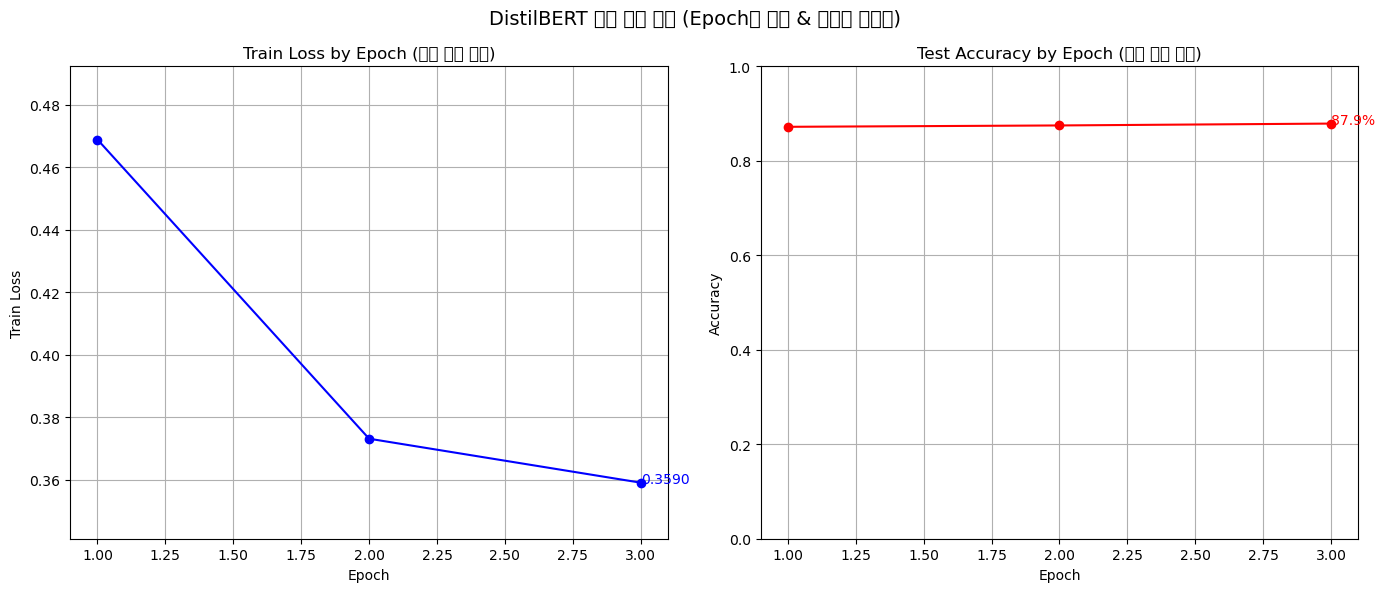

시각화 완료! 아래 그래프는
1) 학습 손실이 어떻게 변하는지
2) 테스트 정확도가 Epoch마다 얼마나 개선되는지
직관적으로 보여줍니다.
높은 정확도에 도달할수록 모델이 뉴스를 잘 분류한다는 의미입니다.


In [1]:
"""
이 코드는 사전 학습된 DistilBERT를 이용해 AG News 기사 분류(4개 클래스)를 수행합니다.

[개요]
1) fancyzhx/ag_news 데이터셋을 불러옵니다 (4개 클래스).
2) Truncation 없이 토큰화를 수행하고, 패딩만 적용하여 DataLoader를 구성합니다.
3) DistilBERT 인코더는 Freeze(동결)하고, 마지막에 (768->4) Linear 레이어를 붙여 다중 클래스 분류를 수행합니다.
4) 학습 시 CrossEntropyLoss를 사용하며, 오직 Test 데이터에 대해서만 정확도를 계산해봅니다.
5) 매 Epoch마다 Train Loss와 Test 정확도를 로깅/시각화합니다.
6) 시각화는 누구나 쉽게 이해할 수 있도록, 그래프와 문구를 풍부하게 표현합니다.
7) 코드 최하단에는 (10) 다중 클래스 정확도 함수, (11) 학습 루프에 대한 라인별 상세 설명을 추가로 제공했습니다. 
   (코드 내부가 아닌, 아래 별도 섹션에 모아두었습니다.)
"""

import logging
import time
import wandb
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import Adam
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm

# -------------------------------------------------
# (1) 로깅 설정
# -------------------------------------------------
logger = logging.getLogger("DistilbertAGNewsFinetuning")
logger.setLevel(logging.INFO)
consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# -------------------------------------------------
# (2) Weights & Biases(W&B) 초기화
# -------------------------------------------------
wandb.init(project="Distilbert-AGNews-Finetuning", name="distilbert-agnews-run")

# -------------------------------------------------
# (3) 디바이스 선택
# -------------------------------------------------
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
logger.info(f"사용할 디바이스: {device}")

# -------------------------------------------------
# (4) DistilBERT Tokenizer 로드
# -------------------------------------------------
startTime = time.time()
distilbertTokenizer = torch.hub.load(
    'huggingface/pytorch-transformers',
    'tokenizer',
    'distilbert-base-uncased'
)
endTime = time.time()
logger.info(f"DistilBERT 토크나이저 로딩 완료 (소요시간: {endTime - startTime:.2f}초)")

# -------------------------------------------------
# (5) AG News 데이터셋 로드 (fancyzhx/ag_news)
# -------------------------------------------------
startTime = time.time()
agnewsDataset = load_dataset("fancyzhx/ag_news")
endTime = time.time()
logger.info(f"AG News 데이터셋 로드 완료 (소요시간: {endTime - startTime:.2f}초)")
logger.info(f"데이터셋 구조: {agnewsDataset}")

# -------------------------------------------------
# (6) collate_fn (Truncation 없이)
# -------------------------------------------------
def collateFunction(batch):
    """
    AG News 샘플들을 받아 (text, label)을 추출하고,
    DistilBERT 토크나이저를 통해 토큰 인덱스로 변환합니다.
    Truncation은 사용하지 않고, padding만 적용합니다.
    최종적으로 (inputIdsTensor, labelsTensor)를 반환합니다.
    """
    textList = []
    labelList = []

    for row in batch:
        textList.append(row["text"])
        labelList.append(row["label"])  # AG News -> 4개 클래스 (0,1,2,3)

    encodedBatch = distilbertTokenizer(
        textList,
        padding=True,   # 가장 긴 시퀀스 기준으로 [PAD] 토큰 삽입
        truncation=False
    )

    inputIdsTensor = torch.LongTensor(encodedBatch["input_ids"])
    labelsTensor = torch.LongTensor(labelList)
    return inputIdsTensor, labelsTensor

# -------------------------------------------------
# (7) DataLoader 구성
# -------------------------------------------------
trainDataLoader = DataLoader(
    agnewsDataset["train"],
    batch_size=64,
    shuffle=True,
    collate_fn=collateFunction
)
testDataLoader = DataLoader(
    agnewsDataset["test"],
    batch_size=64,
    shuffle=False,
    collate_fn=collateFunction
)
logger.info(f"DataLoader 준비 완료. Train 샘플: {len(agnewsDataset['train'])}, Test 샘플: {len(agnewsDataset['test'])}")

# -------------------------------------------------
# (8) 모델 정의 (DistilBERT + Linear(768->4))
# -------------------------------------------------
class DistilbertNewsClassifier(nn.Module):
    """
    DistilBERT 인코더를 동결(Freeze)하고,
    마지막에 4개 클래스를 분류하는 Linear 레이어를 추가합니다.
    """
    def __init__(self):
        super().__init__()
        self.distilbertEncoder = torch.hub.load(
            'huggingface/pytorch-transformers',
            'model',
            'distilbert-base-uncased'
        )
        self.classifierLayer = nn.Linear(768, 4)

    def forward(self, inputIds):
        outputs = self.distilbertEncoder(inputIds)
        hiddenStates = outputs["last_hidden_state"]
        clsEmbedding = hiddenStates[:, 0, :]
        logits = self.classifierLayer(clsEmbedding)  # shape: [batch_size, 4]
        return logits

model = DistilbertNewsClassifier()

# DistilBERT 파라미터를 Freeze
for param in model.distilbertEncoder.parameters():
    param.requires_grad = False

model = model.to(device)
logger.info("DistilbertNewsClassifier 생성 및 DistilBERT 동결(Freeze) 완료.")

# -------------------------------------------------
# (9) 학습 준비: CrossEntropyLoss + Adam
# -------------------------------------------------
lossFunction = nn.CrossEntropyLoss()
learningRate = 0.001
optimizer = Adam(model.parameters(), lr=learningRate)
epochCount = 3

logger.info(f"학습 준비 완료: Loss={lossFunction}, LR={learningRate}, Epoch={epochCount}")

# -------------------------------------------------
# (10) 다중 클래스 정확도 (Test 전용)
# -------------------------------------------------
def calculateTestAccuracy(model, dataLoader):
    """
    오직 testDataLoader에 대해서만 정확도를 계산한다고 가정.
    (4개 클래스 중 argmax 사용)
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputIdsTensor, labelsTensor in dataLoader:
            inputIdsTensor = inputIdsTensor.to(device)
            labelsTensor = labelsTensor.to(device)

            outputs = model(inputIdsTensor)
            predictions = torch.argmax(outputs, dim=-1)
            total += labelsTensor.size(0)
            correct += (predictions == labelsTensor).sum().item()

    return correct / total

# -------------------------------------------------
# (11) 학습 루프
# -------------------------------------------------
trainLossList = []
testAccuracyList = []

overallStartTime = time.time()
logger.info("학습 루프 시작...")

for epochIndex in range(epochCount):
    logger.info(f"====== 에폭 {epochIndex+1}/{epochCount} 시작 ======")
    epochStartTime = time.time()

    model.train()
    totalLoss = 0.0

    for inputIdsTensor, labelsTensor in tqdm(trainDataLoader, desc=f"Epoch {epochIndex+1}/{epochCount}", unit="batch"):
        inputIdsTensor = inputIdsTensor.to(device)
        labelsTensor = labelsTensor.to(device)

        optimizer.zero_grad()
        logits = model(inputIdsTensor)  
        lossValue = lossFunction(logits, labelsTensor)
        lossValue.backward()
        optimizer.step()

        totalLoss += lossValue.item()

    avgTrainLoss = totalLoss / len(trainDataLoader)
    trainLossList.append(avgTrainLoss)

    # 오직 Test 데이터에 대해서만 정확도 측정
    testAcc = calculateTestAccuracy(model, testDataLoader)
    testAccuracyList.append(testAcc)

    epochEndTime = time.time()
    epochDuration = epochEndTime - epochStartTime

    logger.info(f"에폭 {epochIndex+1}/{epochCount} 종료 -> 평균 Train Loss: {avgTrainLoss:.4f}, "
                f"Test Acc: {testAcc:.3f}, "
                f"에폭 시간: {epochDuration:.2f}초")

    wandb.log({
        "Epoch": epochIndex+1,
        "Train Loss": avgTrainLoss,
        "Test Accuracy": testAcc,
        "Epoch Time(sec)": epochDuration
    })

overallEndTime = time.time()
logger.info(f"학습 완료 (총 소요시간: {overallEndTime - overallStartTime:.2f}초)")

# -------------------------------------------------
# (12) 시각화 (Train Loss, Test Accuracy)
# -------------------------------------------------
plt.figure(figsize=(14, 6))

# (12-a) Train Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochCount+1), trainLossList, marker='o', color='blue')
plt.title("Train Loss by Epoch (뉴스 기사 분류)")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.grid(True)
plt.text(epochCount, trainLossList[-1],
         f"{trainLossList[-1]:.4f}", color='blue', fontsize=10,
         horizontalalignment='left')
plt.ylim(min(trainLossList)*0.95, max(trainLossList)*1.05)

# (12-b) Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochCount+1), testAccuracyList, marker='o', color='red')
plt.title("Test Accuracy by Epoch (뉴스 기사 분류)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.text(epochCount, testAccuracyList[-1],
         f"{testAccuracyList[-1]*100:.1f}%", color='red', fontsize=10,
         horizontalalignment='left')

plt.suptitle("DistilBERT 뉴스 분류 결과 (Epoch별 손실 & 테스트 정확도)", fontsize=14)
plt.tight_layout()
plt.show()

logger.info("시각화 완료! 아래 그래프는\n"
            "1) 학습 손실이 어떻게 변하는지\n"
            "2) 테스트 정확도가 Epoch마다 얼마나 개선되는지\n"
            "직관적으로 보여줍니다.\n"
            "높은 정확도에 도달할수록 모델이 뉴스를 잘 분류한다는 의미입니다.")